In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import optuna
import lightgbm as lgbm

from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from scipy.stats import norm

# Source:

[Moro et al., 2014] S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014


# Data Set Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


## Attribute Information:

Input variables:
### bank client data:
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
### related with the last contact of the current campaign:
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
### other attributes:
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
### social and economic context attributes
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

### Output variable (desired target):
21. y - has the client subscribed a term deposit? (binary: 'yes','no')

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

# Load Data

In [2]:
data = pd.read_csv(r"M:\data\bank_marketing\bank-additional-full.csv", delimiter=";")
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


# Split Train/Test

In [3]:
#to ensure equal distribution of labels stratify by label
np.random.seed(35681099)
tr_size = 0.9 #10% of data for testing
#shuffle daata
n = len(data)
shuffle_idx = np.arange(n)
np.random.shuffle(shuffle_idx)
data = data.iloc[shuffle_idx]

#stratify by y
strat_groups = data['y'].unique()

tr_idxs = []
te_idxs = []
for group in strat_groups:
    idxs = data[data['y']==group].index
    
    split_idx = int(tr_size*len(idxs))
    tr_idxs.append(idxs[:split_idx].to_list())
    te_idxs.append(idxs[split_idx:].to_list())

tr_idx = []
list(map(tr_idx.extend, tr_idxs))

te_idx = []
list(map(te_idx.extend, te_idxs))

tr_data = data.iloc[tr_idx].copy()
te_data = data.iloc[te_idx].copy()

In [4]:
def plot_categorical(data, column, order=None):
    #plots probability of subscribing for categories in categorical column
    categories = data[column].unique()
    
    #assert categories.dtype==np.dtype('object'), "categorical columns only"
    
    heights = [] #height of barplots (probabilities)
    ns = [] #number of samples in category
    
    for cat in categories: #collect probabilities
        cat_df = data[data[column]==cat].y
        n = len(cat_df)
        p = cat_df.value_counts()/n
        ns.append(n)
        try:
            heights.append(p.loc['yes'])
        except KeyError:
            heights.append(0)
    
    if order==None:
        sorted_cats = sorted(zip(heights, categories, ns)) #sort by probs  
    else:
        sorted_cats = sorted(zip(heights, categories, ns), key=lambda s: order.index(s[1]))
    

    t = lambda items, i: [item[i] for item in items] 
    heights = [h[0] for h in sorted_cats]
    categories = [c[1] for c in sorted_cats]
    ns = [n[2] for n in sorted_cats]

        
    #plot
    fig, ax = plt.subplots(figsize=(12,7))
    bars = ax.bar(x=categories, height=heights)
    
    #label bar with p
    for i,bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x()+bar.get_width()/2, height, "n = %.d" % (ns[i],), ha='center', va='bottom')
        
    ax.set_ylabel("% subscribed", fontsize=14)
    ax.set_xlabel(column, fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

## Categorical Variables Interaction on Target

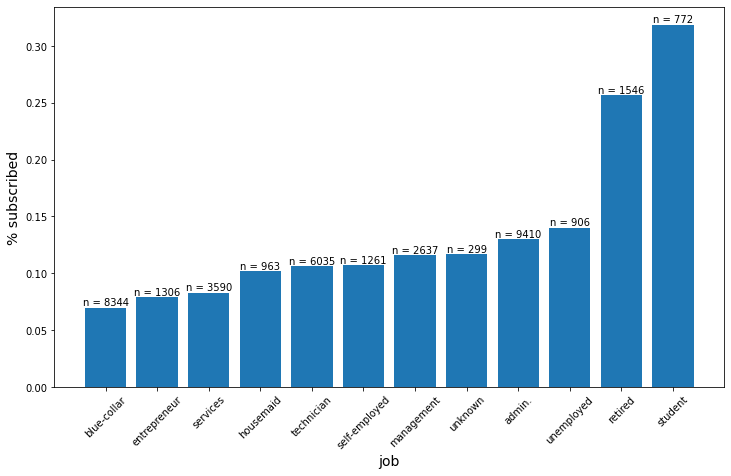

In [5]:
plot_categorical(tr_data, 'job')

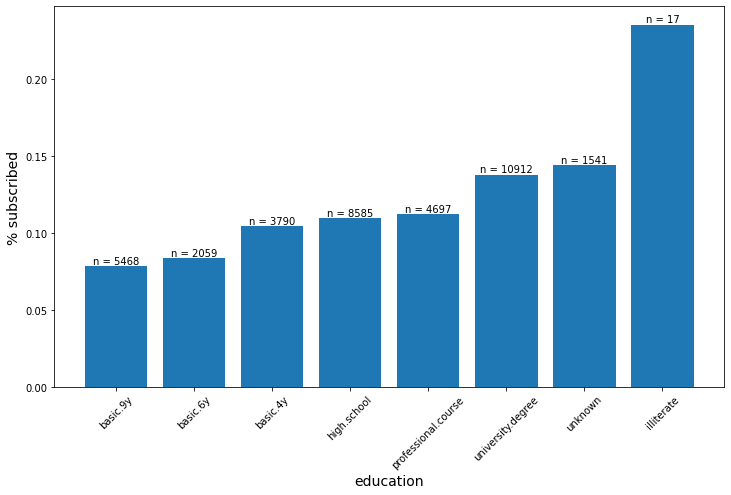

In [6]:
plot_categorical(tr_data, 'education')

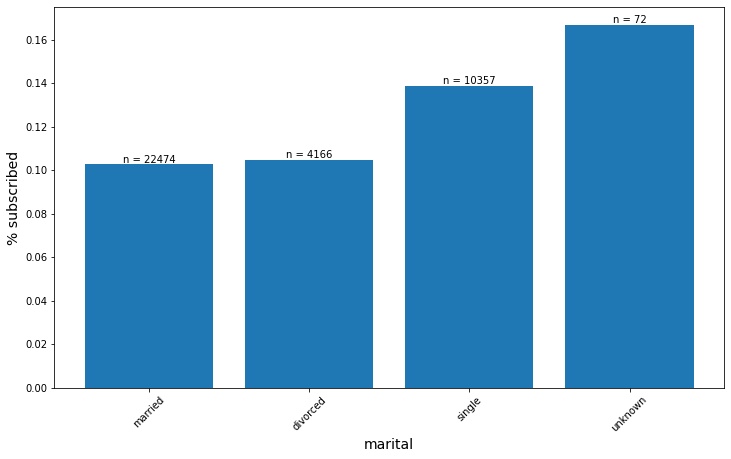

In [7]:
plot_categorical(tr_data, 'marital')

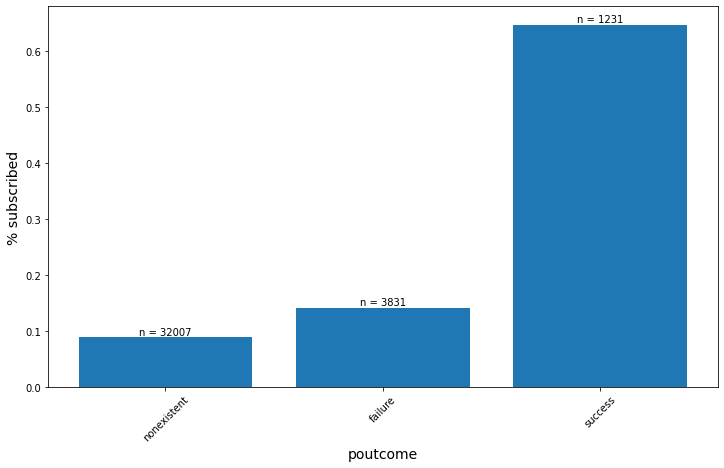

In [8]:
plot_categorical(tr_data, 'poutcome')

## Month/Day Impact on Subscriptions

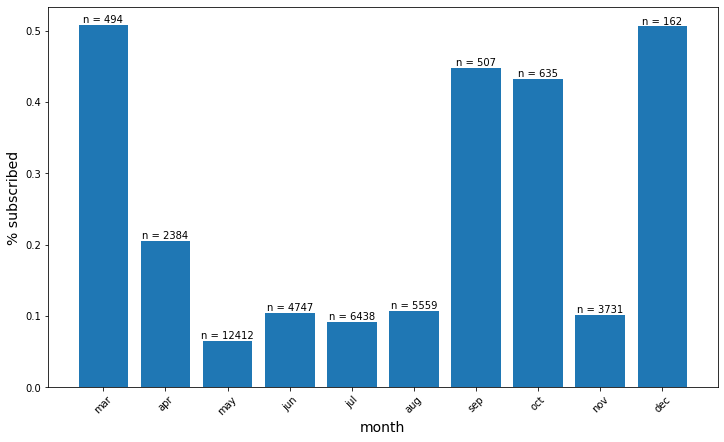

In [9]:
order = ['jan', 'feb' , 'mar', 'apr', 'may', 'jun',
       'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
plot_categorical(tr_data, 'month', order=order)

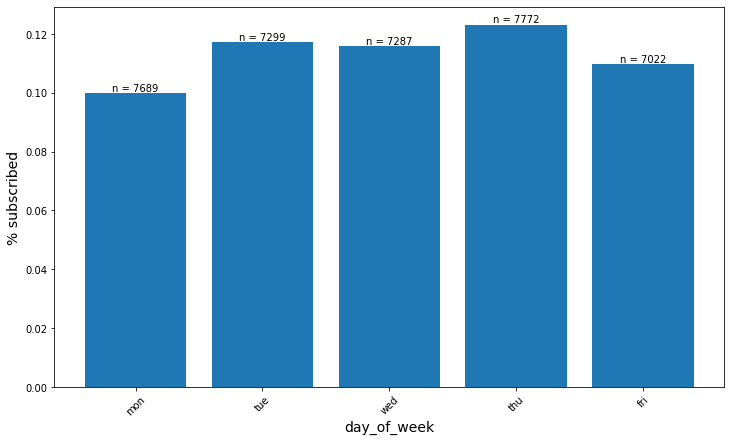

In [10]:
order = ['mon', 'tue', 'wed', 'thu', 'fri']
plot_categorical(tr_data, 'day_of_week', order=order)

#### Don't Make Calls on Mondays (Hypothesis Testing)
Note the following assumes customers were called according to some random process (since we don't 
know the exact process that these calls were made according to; we just assume this assumption isn't violated too harshly).

In [11]:
enc_y = tr_data.replace(['no', 'yes'], [0, 1])
row_df = enc_y[enc_y['day_of_week']!='mon']#rest of week 
mon_df = enc_y[enc_y['day_of_week']=='mon'] #mondays

n_mon = len(mon_df)
n_row = len(row_df)
p_mon = mon_df['y'].sum()/n_mon
p_row = row_df['y'].sum()/n_row
p_pool = (n_mon*p_mon + n_row*p_row)/(n_mon+n_row)
z = p_mon-p_row
z = z / (p_pool * (1-p_pool) * (1/n_mon + 1/n_row))
norm.cdf(z)

0.0

## Numerical Interaction on Target

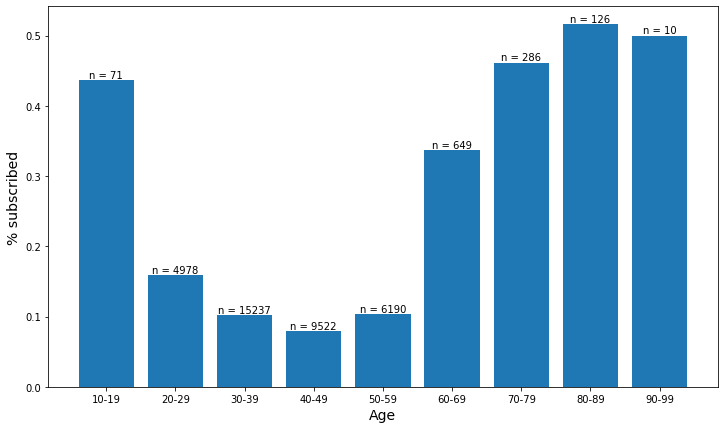

In [12]:
fig, ax = plt.subplots(figsize=(12,7))

ps = []
ns = []
xs = []
for i in range(1,10):
    age1, age2 = 10*i, 10*(i+1)
    age_df = tr_data[(tr_data['age']>=age1) & (tr_data['age']<age2)]
    n = len(age_df)
    p = (age_df['y']=='yes').sum()/n
    ps.append(p)
    ns.append(n)
    xs.append(f"{age1}-{age2-1}")

bars = ax.bar(x=xs, height=ps)

for i,bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x()+bar.get_width()/2, height, 'n = %.d' % (ns[i],), ha='center', va='bottom')
    
ax.set_ylabel('% subscribed', fontsize=14)
ax.set_xlabel('Age', fontsize=14)
plt.show()

In [13]:
def correlation_indicators(data, indicator):
    
    inds = tr_data[indicator].unique()
    ps = []
    for ind_value in inds:
        ind_df = tr_data[tr_data[indicator]==ind_value]
        p = (ind_df['y']=='yes').sum() / len(ind_df)
        ps.append(p)
        
    return np.corrcoef(inds, ps)[0,1]

In [14]:
indicators = ['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
sub_chance = [correlation_indicators(tr_data, indicator) for indicator in indicators]

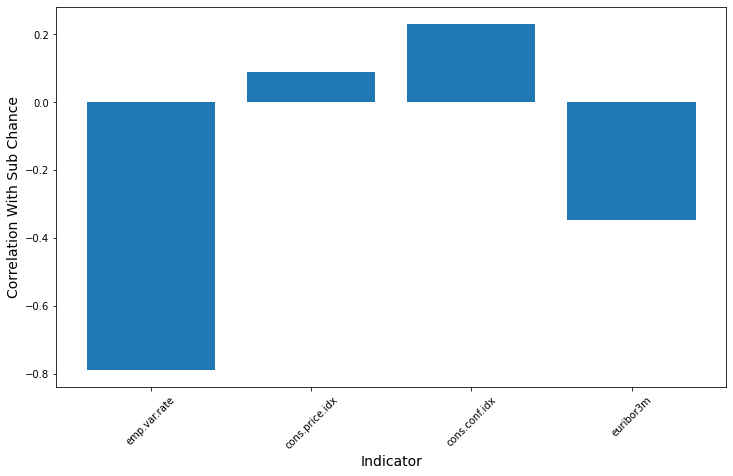

In [15]:
fig, ax = plt.subplots(figsize=(12,7))
bars = ax.bar(x=indicators, height=sub_chance)
        
ax.set_ylabel("Correlation With Sub Chance", fontsize=14)
ax.set_xlabel("Indicator", fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [16]:
def preprocess(data):
    features, targets = data.loc[:, data.columns!='y'].copy(), data.loc[:, 'y'].copy()
    
    #remove columns
    features = features.drop(columns=['duration', 'day_of_week', 'month'])
    
    #group labels within features
    
    #dtypes
    feature_dtypes = features.dtypes
    
    ### Jobs
    job_type1 = ['blue-collar', 'services', 'housemaid', 'self-employed']
    job_type2 = ['entrepreneur', 'technician', 'management', 'admin.']
    job_type3 = ['unknown', 'unemployed', 'retired', 'student']
    job_types = [job_type1, job_type2, job_type3]
    job_replace = {'job':{job:i for i, job_type in enumerate(job_types) for job in job_type}}
    
    ### Education
    edu_type1 = ['basic.9y', 'basic.6y', 'basic.4y', 'illiterate']
    edu_type2 = ['high.school', 'professional.course']
    edu_type3 = ['university.degree', 'unknown']
    edu_types = [edu_type1, edu_type2, edu_type3]
    edu_replace = {'education':{edu:i for i, edu_type in enumerate(edu_types) for edu in edu_type}}
    
    ### Marital
    mar_type1 = ['married', 'divorced']
    mar_type2 = ['unknown', 'single']
    mar_types = [mar_type1, mar_type2]
    mar_replace = {'marital': {mar:i for i,mar_type in enumerate(mar_types) for mar in mar_type}}
    
    ### Default
    def_replace = {'default':{'yes':0, 'unknown':0, 'no':1}}

    ### Loan
    loan_replace = {'loan':{'no':0, 'unknown':0, 'yes':1}}

    ### Housing
    hou_replace = {'housing':{'no':0, 'unknown':0, 'yes':1}}


    ### Previous Outcome
    pout_replace = {'poutcome':{'nonexistent':0, 'failure':0, 'success':1}}
    
    #build replace dictionary 
    group_features = {}
    features_dicts = [job_replace, edu_replace, mar_replace, 
                      def_replace, loan_replace, hou_replace, pout_replace]
    
    for d in features_dicts:
        for k, v in d.items():
            group_features.setdefault(k, v)
            
    
    #replace labels
    features = features.replace(group_features)
    
    #one hot encode features
    features_categoricals = features.loc[:, feature_dtypes=='object']
    features_numerical = features.loc[:, feature_dtypes!='object']
    encoded_categoricals = [pd.get_dummies(features_categoricals[col], prefix=col, drop_first=True)
                            for col in features_categoricals.columns]
    features = pd.concat([features_numerical, *encoded_categoricals], axis=1)
    
    #encode target
    targets = targets.replace(['no', 'yes'], [0, 1])
    
    return features, targets

In [17]:
X_tr, y_tr = preprocess(tr_data)

In [18]:
def objective(trial, X, y):
    param_grid = {
    # "device_type": trial.suggest_categorical("device_type", ['gpu']),
    "n_estimators": trial.suggest_categorical("n_estimators", [8000, 10000, 12000, 14000]),
    "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3),
    "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
    "max_depth": trial.suggest_int("max_depth", 3, 12),
    "reg_alpha": trial.suggest_int("reg_alpha", 0, 100, step=5), #lambda l1
    "reg_lambda": trial.suggest_int("reg_lambda", 0, 100, step=5), #lambda l2
    "min_child_samples": trial.suggest_int("min_child_samples", 200, 10000, step=100),
    "min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
    "subsample": trial.suggest_float(
    "subsample", 0.2, 0.95, step=0.05 #bagging frac
    ), 
    "subsample_freq": trial.suggest_categorical("subsample_freq", [1]), #bagging freq
    "colsample_bytree": trial.suggest_float(
        "colsample_bytree", 0.2, 0.95, step=0.05 #feature frac
        ),
    "max_bin": trial.suggest_int("max_bin", 15, 205, step=10)    
    }
    folds = 5
    cv = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1121218)

    cv_scores = np.empty(folds)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", n_jobs=-1, verbose=-1, **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            verbose=-1,
            callbacks=[
                lgbm.early_stopping(100, verbose=False)
            ],
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = metrics.log_loss(y_test, preds)

    return np.mean(cv_scores)

In [19]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
func = lambda trial: objective(trial, X_tr, y_tr)
study.optimize(func, n_trials=100)

[I 2022-08-08 15:56:51,454] A new study created in memory with name: LGBM Classifier
[I 2022-08-08 15:56:52,090] Trial 0 finished with value: 0.353086607189483 and parameters: {'n_estimators': 10000, 'learning_rate': 0.14732442327623468, 'num_leaves': 1340, 'max_depth': 3, 'reg_alpha': 15, 'reg_lambda': 35, 'min_child_samples': 8200, 'min_split_gain': 3.3237823587746935, 'subsample': 0.45, 'subsample_freq': 1, 'colsample_bytree': 0.8500000000000001, 'max_bin': 135}. Best is trial 0 with value: 0.353086607189483.
[I 2022-08-08 15:56:53,107] Trial 1 finished with value: 0.29174561383478076 and parameters: {'n_estimators': 8000, 'learning_rate': 0.14001504599372627, 'num_leaves': 680, 'max_depth': 10, 'reg_alpha': 100, 'reg_lambda': 45, 'min_child_samples': 2900, 'min_split_gain': 9.583386643193064, 'subsample': 0.95, 'subsample_freq': 1, 'colsample_bytree': 0.6000000000000001, 'max_bin': 125}. Best is trial 1 with value: 0.29174561383478076.
[I 2022-08-08 15:56:56,441] Trial 2 finished w

In [20]:
print(f"\tBest value (binary_logloss): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (binary_logloss): 0.27259
	Best params:
		n_estimators: 10000
		learning_rate: 0.24373962048529677
		num_leaves: 1560
		max_depth: 12
		reg_alpha: 5
		reg_lambda: 65
		min_child_samples: 900
		min_split_gain: 0.5947229526922257
		subsample: 0.8
		subsample_freq: 1
		colsample_bytree: 0.8500000000000001
		max_bin: 175


In [21]:
params = study.best_params
model = lgbm.LGBMClassifier(objective="binary", **params)
model.fit(X_tr, y_tr, verbose=0)

LGBMClassifier(colsample_bytree=0.8500000000000001,
               learning_rate=0.24373962048529677, max_bin=175, max_depth=12,
               min_child_samples=900, min_split_gain=0.5947229526922257,
               n_estimators=10000, num_leaves=1560, objective='binary',
               reg_alpha=5, reg_lambda=65, subsample=0.8, subsample_freq=1)

In [22]:
#Train 
tr_p = model.predict_proba(X_tr)
print(f"Train logloss: {metrics.log_loss(y_tr, tr_p)}, Train AUC: {metrics.roc_auc_score(y_tr, tr_p[:, 1])}")

#Test Dataset
X_te, y_te = preprocess(te_data)
te_p = model.predict_proba(X_te)
print(f"Test logloss: {metrics.log_loss(y_te, te_p)}, Test AUC: {metrics.roc_auc_score(y_te, te_p[:, 1])}")

Train logloss: 0.2585741424100838, Train AUC: 0.8317305654275873
Test logloss: 0.258137883775799, Test AUC: 0.8237172233673613


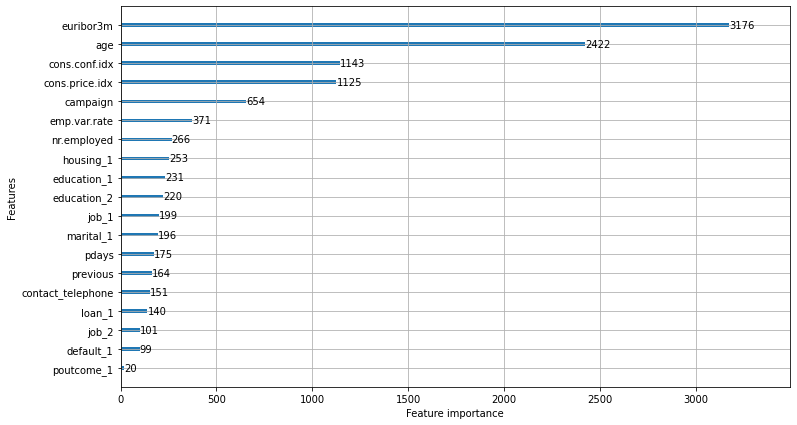

In [23]:
fig, ax = plt.subplots(figsize=(12,7))
lgbm.plot_importance(model, ax=ax)
ax.set_title("")
plt.show()

In [24]:
te_data.loc[:, 'y_p'] = te_p[:,1]

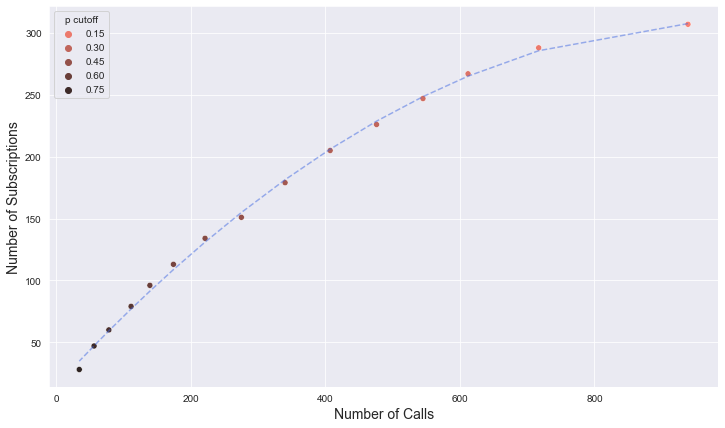

In [25]:
ys = te_data[['y', 'y_p']].copy()
ys = ys.replace(['no', 'yes'], [0, 1])

p_cutoff = np.arange(0.1, 0.85, 0.05)

n = len(p_cutoff)
num_calls = np.empty(n, dtype=np.int32)
num_subs = np.empty(n, dtype=np.int32)

for i, p in enumerate(p_cutoff):
    ys_cutoff = ys[ys['y_p']>p]
    num_calls[i] = len(ys_cutoff)
    num_subs[i] = ys_cutoff['y'].sum()
    

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12,7))

z = np.polyfit(num_calls, num_subs, 2)
trend_y = [z[0]*np.square(n)+z[1]*n+z[2] for n in num_calls]
z = np.polyfit(num_calls, num_subs, 2)
pal = sns.color_palette("dark:salmon_r", as_cmap=True)
sns.scatterplot(x=num_calls, y=num_subs, hue=p_cutoff, palette=pal)
ax.plot(num_calls, trend_y, color=r'#4169E1', linestyle='--', alpha=0.5)

ax.set_xlabel('Number of Calls', fontsize=14)
ax.set_ylabel('Number of Subscriptions', fontsize=14)
ax.legend(title='p cutoff')
plt.show()